In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [14]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4106820854026118104
xla_global_id: -1
]


In [15]:
print(tf.config.list_physical_devices('GPU'))

[]


In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    './dataset/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    './dataset/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    './dataset/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 387 images belonging to 3 classes.
Found 95 images belonging to 3 classes.
Found 482 images belonging to 3 classes.


In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes, adjust for your case
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the Trained Model
model.save('trained_model.h5')
# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Epoch 1/100
12/12 [==============================] - 14s 1s/step - loss: 1.0416 - accuracy: 0.4789 - val_loss: 0.9778 - val_accuracy: 0.5312
Epoch 2/100
12/12 [==============================] - 13s 1s/step - loss: 0.8354 - accuracy: 0.6797 - val_loss: 0.8889 - val_accuracy: 0.5469
Epoch 3/100
12/12 [==============================] - 11s 873ms/step - loss: 0.6009 - accuracy: 0.7408 - val_loss: 1.3674 - val_accuracy: 0.5000
Epoch 4/100
12/12 [==============================] - 9s 791ms/step - loss: 0.3872 - accuracy: 0.8113 - val_loss: 1.1045 - val_accuracy: 0.5938
Epoch 5/100
12/12 [==============================] - 9s 791ms/step - loss: 0.2243 - accuracy: 0.9155 - val_loss: 1.3604 - val_accuracy: 0.5469
Epoch 6/100
12/12 [==============================] - 9s 792ms/step - loss: 0.2526 - accuracy: 0.9211 - val_loss: 1.3219 - val_accuracy: 0.5000
Epoch 7/100
12/12 [==============================] - 9s 782ms/step - loss: 0.3379 - accuracy: 0.8676 - val_loss: 0.9376 - val_accuracy: 0.6562
Ep

KeyboardInterrupt: 

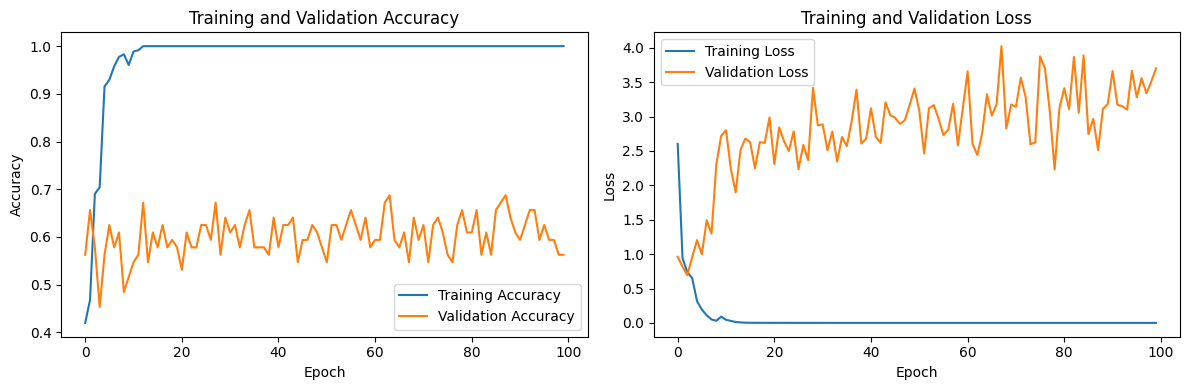

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

16/16 [==============================] - 9s 570ms/step


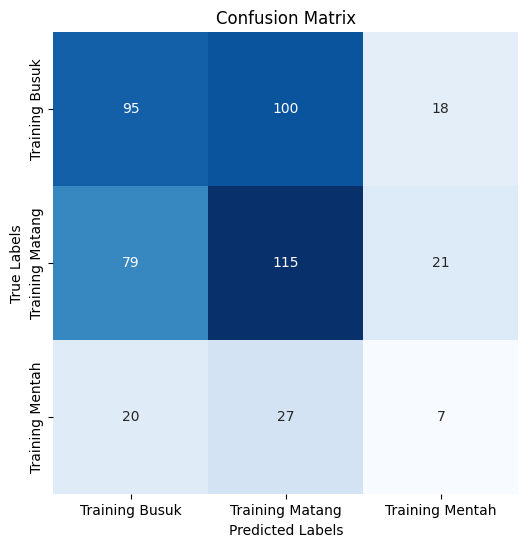

                 precision    recall  f1-score   support

 Training Busuk       0.49      0.45      0.47       213
Training Matang       0.48      0.53      0.50       215
Training Mentah       0.15      0.13      0.14        54

       accuracy                           0.45       482
      macro avg       0.37      0.37      0.37       482
   weighted avg       0.45      0.45      0.45       482



In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_generator.classes

# Confusion matrix
cm = confusion_matrix(true_classes, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_classes, y_pred_classes, target_names=test_generator.class_indices.keys()))